# Import Library

In [1]:
import os
import re
import json
import xml.etree.ElementTree as ET
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

# Functions

In [2]:
def get_namespace(element):
    m = re.match(r'\{.*\}', element.tag)
    if m:
        tag = m.group(0)
    else:
        tag = ''
    return  tag

In [3]:
def parse_data(root):
    list_records = list()
    xml_nms = get_namespace(root)

    list_elems = root.findall(f'{xml_nms}logitem')
    n_all_elems = len(list_elems)
    nth_percent_display = n_all_elems // 10

    xml_tag_mapper = {
        f'{xml_nms}id': 'log_id',
        f'{xml_nms}timestamp': 'log_timestamp',
        f'{xml_nms}contributor/{xml_nms}username': 'user_name',
        f'{xml_nms}contributor/{xml_nms}id': 'user_id',
        f'{xml_nms}comment': 'user_comment',
        f'{xml_nms}type': 'action_type',
        f'{xml_nms}action': 'action',
        f'{xml_nms}logtitle': 'log_title'
    }

    for i, elem in enumerate(list_elems):
        record = dict()

        for xml_tag, col_name in xml_tag_mapper.items():
            try:
                value = elem.find(xml_tag).text
            except AttributeError:
                value = None
            
            record[col_name] = value

        list_records.append(record)

        if i % nth_percent_display == 0:
            progress = int(i / nth_percent_display)
            if progress <= 9 and progress > 0:
                print("progress: {}% {}".format(10 * progress, "." * progress))
            else:
                if i == 10:
                    print("done")

    df = pd.read_json(json.dumps(list_records), orient='records')

    return df

In [4]:
def parse_column_header(sql):
    s = re.search(r'CREATE TABLE .* \(((.* NOT NULL,)+)', sql, re.DOTALL)
    if s:
        col_names = s.group(1)
        col_names = col_names.replace('\n', '')
        col_names = ' '.join(col_names.split())
        
        list_new_col_names = list()

        for col_name in col_names.split(','):
            if len(col_name) > 0:
                m = re.match(r'(.*) .*\(\d+\).* NOT NULL', col_name)
                col_name = m.group(1)
                col_name = col_name.replace('`', '').strip()
                list_new_col_names.append(col_name)
        
        return list_new_col_names
    else:
        return None

In [5]:
def parse_query(sql):
    lang_proficiency = re.search('INSERT INTO .* VALUES (.*);', sql).group(1)
    list_lang_prof = lang_proficiency.replace('),(', ')_(').split('_')
    list_lang_prof = list(map(lambda x: x[1:-1].replace('\'', '').split(','), list_lang_prof))
    
    header = parse_column_header(sql)
    if header is None:
        header = ['babel_user', 'babel_lang', 'babel_level']

    df = pd.DataFrame(list_lang_prof, columns=header)

    return df

In [18]:
def process_log(df):
    df['log_timestamp'] = df['log_timestamp'].str.replace('T', ' ')
    df['log_timestamp'] = df['log_timestamp'].str.replace('Z', '')
    df['log_timestamp'] = pd.to_datetime(df['log_timestamp'], format='%Y-%m-%d %H:%M:%S')

    df.drop(columns=['user_name', 'log_title'], inplace=True)

    df.dropna(subset='user_id', inplace=True)
    df['user_id'] = df['user_id'].astype(int)

    df.sort_values(by=['user_id', 'log_timestamp'], ascending=[True, True], inplace=True, ignore_index=True)

In [7]:
def get_log_unblock(df):
    df_user_block = df.loc[df['action'].isin(['block', 'reblock']), ['log_id', 'user_id', 'log_timestamp']]
    df_user_unblock = df.loc[df['action'].eq('unblock'), ['user_id', 'log_timestamp', 'user_comment']]

    df_user_block.sort_values(by='log_timestamp', inplace=True)
    df_user_unblock.sort_values(by='log_timestamp', inplace=True)

    df_comment = pd.merge_asof(df_user_block, df_user_unblock, by='user_id', on='log_timestamp', tolerance=pd.Timedelta('2d'), direction='forward')
    df_comment['user_comment'] = df_comment['user_comment'].fillna('')
    df_comment['user_comment'] = df_comment['user_comment'].str.lower()

    list_log_id = df_comment.loc[df_comment['user_comment'].str.contains('ผิด|พลาด|ok|false', regex=True), 'log_id']
    list_log_id = list_log_id.tolist()

    return list_log_id

In [8]:
def calculate_target(df):
    list_unblock_log = get_log_unblock(df)

    # <df>.iloc[::-1].shift(1)
    df_rev = df.iloc[::-1]
    df_rev['next_action'] = df_rev.groupby('user_id')['action'].shift(1)
    df_rev['is_block'] = df_rev['next_action'].isin(['block', 'reblock']) & ~df_rev['log_id'].isin(list_unblock_log)

    n_blocks = df_rev.groupby('user_id', sort=False).rolling('2d', min_periods=1, on='log_timestamp')['is_block'].sum().iloc[::-1]
    n_blocks = n_blocks.astype(int)
    n_blocks = n_blocks.reset_index(level=0, drop=True)
    n_blocks.reset_index(drop=True, inplace=True)

    df['n_blocks'] = n_blocks

    df['is_block_next_period'] = df['n_blocks'].ge(3).astype(int)

    df.drop(columns=['n_blocks'], inplace=True)

In [9]:
def fit_encoder(df):
    onehot_encoder = OneHotEncoder(sparse_output=False, dtype=np.int8, handle_unknown='ignore')
    onehot_encoder.fit(df[['action', 'action_type']])

    return onehot_encoder

In [10]:
def transform_encoder(df, onehot_encoder):
    arr = onehot_encoder.transform(df[['action', 'action_type']])
    col_name = onehot_encoder.get_feature_names_out()
    index = df.index

    df_onehot = pd.DataFrame(arr, columns=col_name, index=index)

    df = pd.concat([df, df_onehot], axis=1)

    return df

In [180]:
def create_features_bad_behavior(df):
    # short pariod (2h)
    df_count_move_short = (df.groupby('user_id')
                    .rolling('2h', min_periods=1, on='log_timestamp')[['action_type_move', 'action_type_delete']]
                    .sum()
                    .reset_index(drop=True))

    df['feat_count_move'] = df_count_move_short['action_type_move'].astype(int).values
    df['feat_count_delete'] = df_count_move_short['action_type_delete'].astype(int).values

    # long period (2d)
    df_count_move_long = (df.groupby('user_id')
                        .rolling('2d', min_periods=1, on='log_timestamp')[['action_type_delete']]
                        .sum()
                        .reset_index(drop=True))

    df['feat_count_delete_hist'] = df_count_move_long['action_type_delete'].astype(int).values - df['feat_count_delete']

    # mins since last delete
    df_delete_timestamp = df.loc[df['action_type_delete'].eq(1), ['log_id', 'log_timestamp']]
    df_delete_timestamp = df_delete_timestamp.rename(columns={'log_timestamp': 'delete_timestamp'})
    df = df.merge(df_delete_timestamp, left_on='log_id', right_on='log_id', how='left')

    df['delete_timestamp'] = df.groupby('user_id')['delete_timestamp'].shift(1)
    df['delete_timestamp'] = df.groupby('user_id')['delete_timestamp'].ffill()
    df['feat_min_since_last_delete'] = (df['log_timestamp'] - df['delete_timestamp']).dt.total_seconds() / 60

    df.drop(columns=['delete_timestamp'], inplace=True)

    # average delete times
    avg_mins_since_last_del = (df.groupby('user_id')
                                .rolling('2h', min_periods=1, on='log_timestamp')[['feat_min_since_last_delete']]
                                .mean()
                                .reset_index(drop=True))
    df['feat_avg_mins_delete'] = avg_mins_since_last_del

In [181]:
def create_feature_contribution(df):
    # average daily contribution
    total_create_action_count = (df.groupby('user_id')
                                    .rolling('7d', min_periods=1, on='log_timestamp')['action_create']
                                    .sum()
                                    .reset_index(drop=True))
    total_create_action_count = total_create_action_count.astype(int)
    df['feat_avg_contribution'] = total_create_action_count / 7

    # contribution vs delete
    # - short pariod (2h)
    df_count_move_short = (df.groupby('user_id')
                            .rolling('2h', min_periods=1, on='log_timestamp')['action_create']
                            .sum()
                            .reset_index(drop=True))
    # - long period (2d)
    df_count_move_long = (df.groupby('user_id')
                        .rolling('2d', min_periods=1, on='log_timestamp')['action_create']
                        .sum()
                        .reset_index(drop=True))

    df['feat_count_contribute_hist'] = df_count_move_long - df_count_move_short
    df['feat_count_contribute_compare'] = df['feat_count_contribute_hist'] / df['feat_count_delete_hist']
    df['feat_count_contribute_compare'] = df['feat_count_contribute_compare'].replace(np.inf, np.nan)

    df.drop(columns='feat_count_contribute_hist', inplace=True)

In [182]:
def create_feature_block_history(df):
    df['action_block_all'] = df[['action_block', 'action_reblock']].sum(axis=1)
    count_recent_blocks = (df.groupby('user_id')
                                    .rolling('7d', min_periods=1, on='log_timestamp')['action_block_all']
                                    .sum()
                                    .reset_index(drop=True))
    df['feat_is_blocked_recently'] = count_recent_blocks.gt(0).astype(int)

    count_recent_unblocks = (df.groupby('user_id')
                                    .rolling('7d', min_periods=1, on='log_timestamp')['action_unblock']
                                    .sum()
                                    .reset_index(drop=True))
    df['feat_is_unblocked_recently'] = count_recent_unblocks.gt(0).astype(int)

    # mins since last delete
    df_block_timestamp = df.loc[df['action_block_all'].eq(1), ['log_id', 'log_timestamp']]
    df_block_timestamp = df_block_timestamp.rename(columns={'log_timestamp': 'block_timestamp'})
    df = df.merge(df_block_timestamp, left_on='log_id', right_on='log_id', how='left')

    df['block_timestamp'] = df.groupby('user_id')['block_timestamp'].shift(1)
    df['block_timestamp'] = df.groupby('user_id')['block_timestamp'].ffill()
    df['feat_day_since_last_block'] = (df['log_timestamp'] - df['block_timestamp']).dt.days

    df.drop(columns=['block_timestamp', 'action_block_all'], inplace=True)

In [183]:
def create_feature_user_comment(df):
    df['refer_comment_bad_user'] = df['user_comment'].str.contains('ก่อกวน')
    df['refer_comment_bad_user'] = df['refer_comment_bad_user'].fillna(0).astype(int)

    count_refer_comment = (df.groupby('user_id')
                                .rolling('2d', min_periods=1, on='log_timestamp')['refer_comment_bad_user']
                                .sum()
                                .reset_index(drop=True))
    df['feat_count_comment_bad_user'] = count_refer_comment

    df.drop(columns='refer_comment_bad_user', inplace=True)

In [184]:
def create_feature_rename_user(df):
    count_rename_users = (df.groupby('user_id')
                                .rolling('2d', min_periods=1, on='log_timestamp')['action_renameuser']
                                .sum()
                                .reset_index(drop=True))
    df['feat_is_rename_user_recently'] = count_rename_users.gt(0).astype(int)

In [197]:
def create_features(df, encoder=None):
    if encoder is None:
        train = True
        encoder = fit_encoder(df)
    else:
        train = False

    df = transform_encoder(df, onehot_encoder=encoder)
    df.drop(columns=['action_type', 'action'], inplace=True)

    create_features_bad_behavior(df)
    create_feature_contribution(df)
    create_feature_block_history(df)
    create_feature_user_comment(df)
    create_feature_rename_user(df)

    list_col_to_drop = ['log_timestamp', 'user_comment', *df.filter(regex='^action_', axis=1).columns.tolist()]
    df.drop(columns=list_col_to_drop, inplace=True)

    if train:
        return (df, encoder)
    else:
        return df

# Import Data

In [201]:
path = Path(os.getcwd())

project_dir = path.parent
raw_data_dir = project_dir / 'data' / 'raw'
process_data_dir = project_dir / 'data' / 'preprocess'

In [12]:
# user log
tree_page_logging = ET.parse(raw_data_dir / 'thwiki-20240920-pages-logging.xml')
root_page_logging = tree_page_logging.getroot()

# language proficiency
with open(raw_data_dir / 'thwiki-20240920-babel.sql', 'r') as f:
    sql_lang_prof = f.read()

In [20]:
df_user_log = parse_data(root=root_page_logging)
df_lang_prof = parse_query(sql_lang_prof)

progress: 10% .
progress: 20% ..
progress: 30% ...
progress: 40% ....
progress: 50% .....
progress: 60% ......
progress: 70% .......
progress: 80% ........
progress: 90% .........


C:\Users\11413929\AppData\Local\Temp\ipykernel_11140\2690832593.py:41: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_json(json.dumps(list_records), orient='records')


In [14]:
df_lang_prof.head(2)

,babel_user,babel_lang,babel_level
0,138412,ab,3
1,91937,af,1


In [15]:
df_user_log.head(2)

,log_id,log_timestamp,user_name,user_id,user_comment,action_type,action,log_title
0,1,2004-12-23T07:51:14Z,Dr.Akarat,174.0,ชาวไอนุ บนเกาะฮอกไกโด ประเทศญี่ปุ่น เมื่อ ค.ศ....,upload,upload,ไฟล์:AinuGroup.jpg
1,2,2004-12-23T09:59:44Z,Dr.Akarat,174.0,เมืองฮาโกดาเตะยามค่ำคืน,upload,upload,ไฟล์:Hakodate.jpg


In [16]:
df_user_block = df_user_log.loc[df_user_log['action'].isin(['block', 'reblock']), ['log_id', 'user_id', 'log_timestamp']]
df_user_unblock = df_user_log.loc[df_user_log['action'].eq('unblock'), ['user_id', 'log_timestamp', 'user_comment']]

df_user_block['log_timestamp'] = pd.to_datetime(df_user_block['log_timestamp'].str.replace('T', ' ').str.replace('Z', ''))
df_user_unblock['log_timestamp'] = pd.to_datetime(df_user_unblock['log_timestamp'].str.replace('T', ' ').str.replace('Z', ''))

df_user_block.sort_values(by='log_timestamp', inplace=True)
df_user_unblock.sort_values(by='log_timestamp', inplace=True)

df_comment = pd.merge_asof(df_user_block, df_user_unblock, by='user_id', on='log_timestamp', tolerance=pd.Timedelta('2d'), direction='forward')

df_comment['user_comment'].value_counts().head(25)

user_comment
เปลี่ยนชื่อผู้ใช้แล้ว                          29
false positive                                 27
แก้ไขเจตนาดี                                   16
OK                                             16
มีช่วงการบล็อกที่ครอบคลุมกว่า                  13
ไม่ได้ก่อกวน                                   11
เปลี่ยนชื่อแล้ว                                10
ปรับช่วงการบล็อกใหม่                           10
แจ้งเปลี่ยนชื่อ                                 8
การแก้ถูกต้องแล้ว                               8
ผิดพลาด                                         7
per [[WP:AN#ข้อความฝากถามแอดมินวิกิพีเดีย]]     7
บล็อกผิดไอพี                                    7
ต้องการระบุเหตุผลในการบล็อกให้ชัดเจน            6
ยกเลิกการบล็อก                                  6
รอตรวจสอบก่อน                                   6
ไม่มีความจำเป็นต้องบล็อกไอพีนาน                 6
อุทธรณ์การบล็อก                                 5
แก้ไขชื่อแล้ว                                   4
ให้เวลาทบทวนตนเองนานมากแล้ว          

There are some keywords which indicates misunderstandings, such as, <code>'false positive'</code>, <code>'ผิด'</code>, <code>'พลาด'</code>, <code>'ok'</code>

# Pre-process

In [21]:
# pre-process log information
process_log(df_user_log)

# create target
calculate_target(df_user_log)

C:\Users\11413929\AppData\Local\Temp\ipykernel_11140\2357546613.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rev['next_action'] = df_rev.groupby('user_id')['action'].shift(1)
C:\Users\11413929\AppData\Local\Temp\ipykernel_11140\2357546613.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rev['is_block'] = df_rev['next_action'].isin(['block', 'reblock']) & ~df_rev['log_id'].isin(list_unblock_log)


In [41]:
df_user_log.loc[df_user_log['is_block_next_period'].eq(1), :].tail(30)

,log_id,log_timestamp,user_id,user_comment,action_type,action,is_block_next_period
1470703,1698502,2024-07-24 14:39:27,401376,เป็นหุ่นเชิดของ Learning Ln,block,block,1
1470715,1703022,2024-08-03 14:33:28,401376,หน้าสำคัญ: พรรคการเมืองที่เสี่ยงต่อการก่อกวนมาก,protect,modify,1
1470716,1703027,2024-08-03 14:37:37,401376,ช่หุ่นเชิดของ Learning Ln,block,block,1
1470717,1703028,2024-08-03 14:37:40,401376,ช่หุ่นเชิดของ Learning Ln,block,block,1
1470725,1704768,2024-08-08 14:10:08,401376,None,thanks,thank,1
1470726,1704781,2024-08-08 14:40:19,401376,[[WP:การก่อกวน|ก่อกวน]]: ไอพีก่อกวนเป็นส่วนใหญ่,block,block,1
1470727,1704782,2024-08-08 14:43:11,401376,[[WP:การก่อกวน|ก่อกวน]]: ก่อกวน,block,block,1
1470728,1704783,2024-08-08 14:44:11,401376,การก่อกวนจำนวนมาก: เป็นหน้าของทีมฟุตบอลที่มีชื...,protect,protect,1
1470729,1705122,2024-08-09 14:18:54,401376,[[WP:การก่อกวน|ก่อกวน]],block,block,1
1470730,1705124,2024-08-09 14:19:50,401376,[[WP:การก่อกวน|ก่อกวน]]: มีการก่อกวนต่อเนื่องจ...,block,block,1


In [42]:
# check the correctnes of target
df_user_log.loc[df_user_log['user_id'].eq(436) & df_user_log['log_timestamp'].between('2007-02-20', '2007-02-22'), :]

,log_id,log_timestamp,user_id,user_comment,action_type,action,is_block_next_period
12998,49464,2007-02-20 15:47:34,436,เนื้อหาเดิม: 'ดั่งดวงหฤทัย' (สร้างโดย '124.121...,delete,delete,1
12999,49465,2007-02-20 15:50:07,436,เนื้อหาเดิม: ''''เหนอะหนะ นุ่มนิ่ม'''',delete,delete,1
13000,49468,2007-02-20 16:11:13,436,ไม่เป็นสารานุกรม,delete,delete,1
13001,49773,2007-02-21 15:08:53,436,เนื้อหาเดิม: 'ทวีปอเมริกาเนือ' (สร้างโดย '125....,delete,delete,1
13002,49774,2007-02-21 15:08:58,436,เนื้อหาเดิม: '{{ลบ}}== ฮ่าฮ่าฮ่า ไอ้หมาขี้แพ้ ...,delete,delete,1
13003,49775,2007-02-21 15:09:23,436,ก่อกวน,delete,delete,1
13004,49799,2007-02-21 16:54:22,436,เนื้อหาเดิม: '{{ลบ}}เป็นเชียร์ ลีดเดอร์ จุฬาลง...,delete,delete,1
13005,49800,2007-02-21 16:56:41,436,เนื้อหาเดิม: '{{ลบ}}จะให้มีอะไรหละ? ก็บอกอยู่ว...,delete,delete,1
13006,49801,2007-02-21 17:00:22,436,ก่อกวนหลายครั้ง,block,block,1
13007,49803,2007-02-21 17:03:31,436,ก่อกวนหลายครั้ง,block,block,0


## Feature Distribution

In [27]:
user_id_blobked = df_user_log.loc[df_user_log['is_block_next_period'].eq(1), 'user_id'].unique()
user_id_regular = df_user_log.loc[~df_user_log['user_id'].isin(user_id_blobked), 'user_id'].unique()

### User Action Count

<Axes: xlabel='action'>

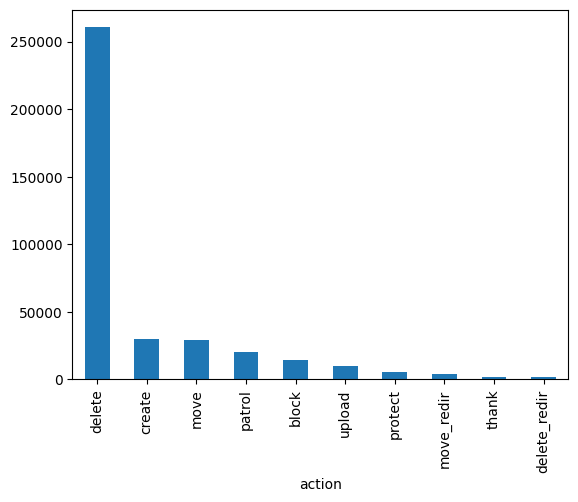

In [28]:
df_user_log.loc[df_user_log['user_id'].isin(user_id_blobked), :].groupby('action').size().sort_values(ascending=False).head(10).plot.bar()

<Axes: xlabel='action'>

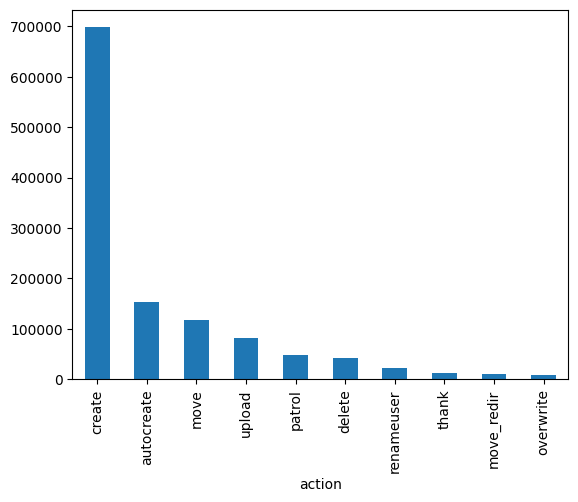

In [29]:
df_user_log.loc[df_user_log['user_id'].isin(user_id_regular), :].groupby('action').size().sort_values(ascending=False).head(10).plot.bar()

When compared type of action between blocked users and regular users, we can see that
- Blocked users mostly cause damage <b>by <u>deleteing</u></b> information from Wikipedia.
- Regular users dedicatedly contribute their knowledge to Wikipedia community <b>by <u>creating</u></b> new information.

### Usage variation by time

In [30]:
a = df_user_log.loc[df_user_log['user_id'].isin(user_id_blobked), :].groupby('action').size().sort_values(ascending=False).head(10).index
b = df_user_log.loc[df_user_log['user_id'].isin(user_id_regular), :].groupby('action').size().sort_values(ascending=False).head(10).index

set(a).intersection(set(b))

{'create', 'delete', 'move', 'move_redir', 'patrol', 'thank', 'upload'}

In [31]:
df_user_log.loc[df_user_log['user_id'].isin(user_id_blobked), :].groupby('action').size().sort_values(ascending=False).head(30).index

Index(['delete', 'create', 'move', 'patrol', 'block', 'upload', 'protect',
       'move_redir', 'thank', 'delete_redir', 'restore', 'overwrite',
       'revision', 'unprotect', 'reblock', 'move_prot', 'modify', 'renameuser',
       'unblock', 'rights', 'event', 'merge', 'create2', 'revert', 'change',
       'newusers', 'whitelist', 'autocreate', 'forcecreatelocal', 'send'],
      dtype='object', name='action')

<Axes: xlabel='log_date'>

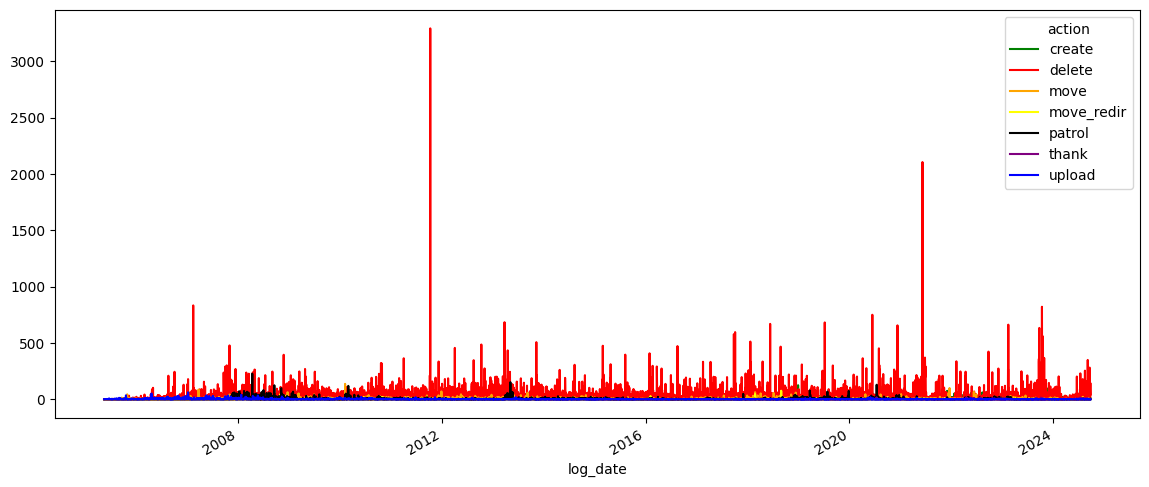

In [32]:
dict_color = dict(create='green', delete='red', move='orange', move_redir='yellow', patrol='black', thank='purple', upload='blue')

list_col = list(dict_color.keys())
list_color = [dict_color.get(x, 'gray') for x in list_col]

df_user_blocked = df_user_log.loc[df_user_log['user_id'].isin(user_id_blobked), :].copy()
df_user_blocked['log_date'] = pd.to_datetime(df_user_blocked['log_timestamp'].dt.date)
df_user_blocked = df_user_blocked.groupby(['log_date', 'action']).size().reset_index().rename(columns={0: 'count'})
df_user_blocked = df_user_blocked.pivot(columns='action', index='log_date', values='count').fillna(0).astype(int)
df_user_blocked.loc[:, list_col].plot(figsize=(14, 6), color=list_color)

<Axes: xlabel='log_date'>

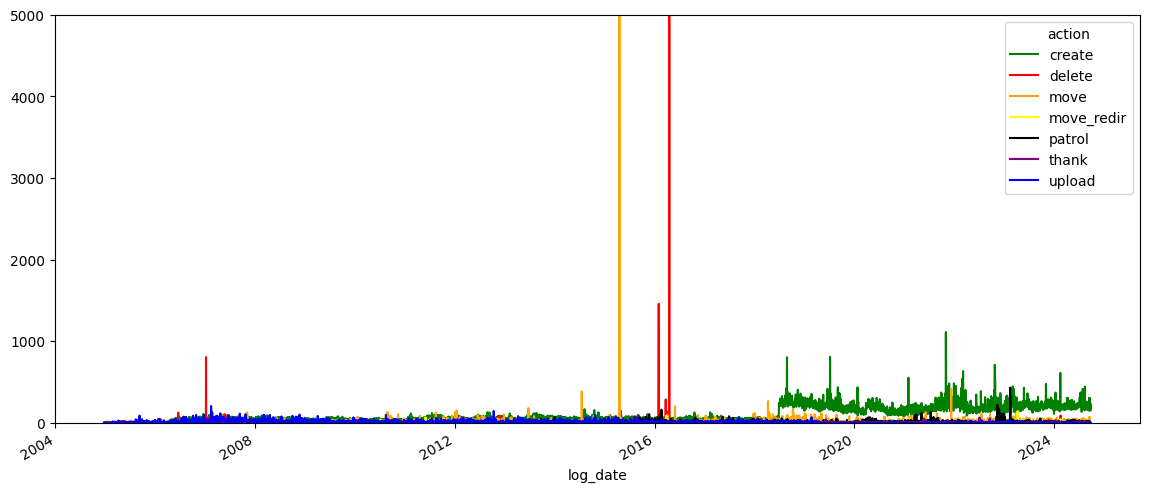

In [33]:
df_user_regular = df_user_log.loc[df_user_log['user_id'].isin(user_id_regular), :].copy()
df_user_regular['log_date'] = pd.to_datetime(df_user_regular['log_timestamp'].dt.date)
df_user_regular = df_user_regular.groupby(['log_date', 'action']).size().reset_index().rename(columns={0: 'count'})
df_user_regular = df_user_regular.pivot(columns='action', index='log_date', values='count').fillna(0).astype(int)
df_user_regular.loc[:, list_col].plot(figsize=(14, 6), color=list_color, ylim=(0, 5000))

When compare common action across different type of users, we got
 - For blocked users, there are no clear trend on <code>'delete'</code> actions -> <b><u>only spikes</u></b> on some days
 - For regular users, there are <b><u>clear trend</u></b> on <code>'delete'</code> actions, however...
    - We can clearly see differnce of trends since the Q2 of 2018 -> more <code>'create'</code> actions
    - There might be a huge maintenance on the website since we can see some outliers on <code>'delete'</code> and <code>'move'</code> actions

<u>Solution</u> :
 - Use the log <b>after '2017-01-01'</b> and put <b>sample weights to focus on more recent data</b>
 - Develop features which can captures <b>sudden changes</b> on <code>'delete'</code> action (or any other related actions, such as <code>'move'</code>)
 - Develop features which can captures <b>constant trend</b> on <code>'create'</code> action (or any other related)
 - More features which might indicate bad user behaviors, such as <code>action_type='protect'</code>, <code>action_type='delete'</code>, keyword 'ก่อกวน' ใน comment, <code>action='renameuser'</code>

In [34]:
df_user_blocked = df_user_log.loc[df_user_log['user_id'].isin(user_id_blobked), :].copy()

df_user_blocked_time = df_user_blocked.loc[df_user_blocked['action'].isin(('block', 'reblock')), ['user_id', 'log_timestamp']].copy()
df_user_blocked_time['block_timestamp'] = df_user_blocked_time['log_timestamp']

df_user_blocked.sort_values(by='log_timestamp', inplace=True)
df_user_blocked_time.sort_values(by='log_timestamp', inplace=True)

df_block_time = pd.merge_asof(df_user_blocked, df_user_blocked_time, by='user_id', on='log_timestamp', direction='forward', allow_exact_matches=False)

df_block_time['days_until_block'] = (df_block_time['block_timestamp'] - df_block_time['log_timestamp']).dt.days

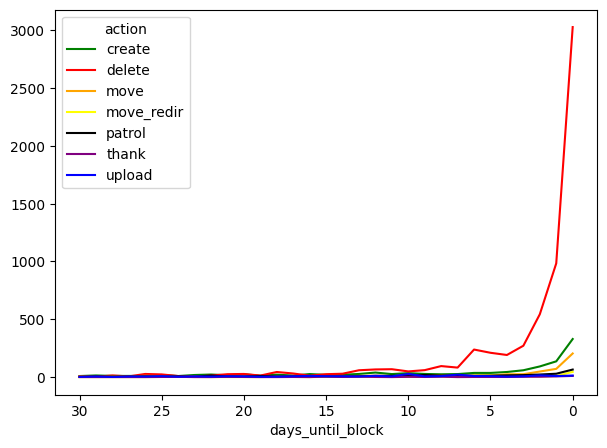

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

df_action_before_block = df_block_time.loc[df_block_time['log_timestamp'].gt('2017-01-01')].groupby(['days_until_block', 'action', 'user_id']).size().rename('count').reset_index()
df_action_before_block = df_action_before_block.groupby(['days_until_block', 'action'])['count'].mean().reset_index()
df_action_before_block = df_action_before_block.pivot(columns='action', index='days_until_block', values='count').fillna(0).astype(int)
df_action_before_block.loc[df_action_before_block.index <= 30, list_col].plot(ax=ax, color=list_color)

ax.xaxis.set_inverted(True)

plt.show()

When calculate average activity count in each remaining days until getting blocked, we can see that
- Average count of <code>'delete'</code> action skyrocketted before getting blocked
- Period of <code>'delete'</code> action is quite short (>2 days and mostly are even within in the same day) 

In [36]:
df_user_blocked = df_user_log.loc[df_user_log['user_id'].isin(user_id_blobked), :].copy()

df_user_blocked_time = df_user_blocked.loc[df_user_blocked['action'].isin(('block', 'reblock')), ['user_id', 'log_timestamp']].copy()
df_user_blocked_time['block_timestamp'] = df_user_blocked_time['log_timestamp']

df_user_blocked.sort_values(by='log_timestamp', inplace=True)
df_user_blocked_time.sort_values(by='log_timestamp', inplace=True)

df_block_time = pd.merge_asof(df_user_blocked, df_user_blocked_time, by='user_id', on='log_timestamp', direction='forward', allow_exact_matches=False)

df_block_time['hours_until_block'] = (df_block_time['block_timestamp'] - df_block_time['log_timestamp']).dt.total_seconds() / 3600

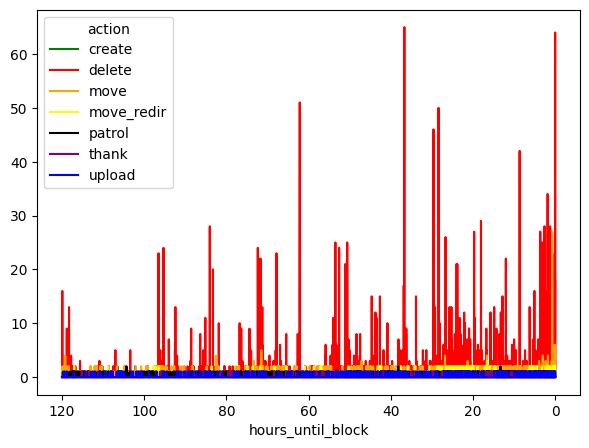

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

df_action_before_block = df_block_time.loc[df_block_time['log_timestamp'].gt('2017-01-01')].groupby(['hours_until_block', 'action', 'user_id']).size().rename('count').reset_index()
df_action_before_block = df_action_before_block.groupby(['hours_until_block', 'action'])['count'].mean().reset_index()
df_action_before_block = df_action_before_block.pivot(columns='action', index='hours_until_block', values='count').fillna(0).astype(int)
df_action_before_block.loc[df_action_before_block.index <= 120, list_col].plot(ax=ax, color=list_color)

ax.xaxis.set_inverted(True)

plt.show()

## Feature Engineering

<u>Feature Idea</u>:
- Delete / Move count -> short + long //
- Time since last delete -> recent + avg //
- Create count //
- Count compare to delete //
- Was blocked + reblocked recently ? //
- Was unblocked recently ? //
- Time since last blocked ? //

In [38]:
time_cutoff = '2024-06-01'

df_train = df_user_log.loc[df_user_log['log_timestamp'].lt(time_cutoff) & df_user_log['log_timestamp'].gt('2017-01-01'), :]
df_test = df_user_log.loc[df_user_log['log_timestamp'].ge(time_cutoff), :]

print("Training set shape: {}".format(df_train.shape))
print("Testing set shape: {}".format(df_test.shape))

Training set shape: (836647, 7)
Testing set shape: (42679, 7)


In [39]:
df_test['is_block_next_period'].value_counts()

is_block_next_period
0    38664
1     4015
Name: count, dtype: int64

In [198]:
df_train, encoder = create_features(df_train)

df_test = create_features(df_test, encoder=encoder)

In [199]:
df_train.head(3)

,log_id,user_id,is_block_next_period,feat_count_move,feat_count_delete,feat_count_delete_hist,feat_avg_contribution,feat_count_contribute_compare,feat_is_blocked_recently,feat_is_unblocked_recently,feat_count_comment_bad_user,feat_is_rename_user_recently
163,831194,7,0,0,1,0,0.000000,NaN,0.0,0.0,0.0,0.0
164,831195,7,0,1,1,0,0.142857,NaN,0.0,0.0,0.0,0.0
165,831196,7,0,1,2,0,0.285714,NaN,0.0,0.0,0.0,0.0


In [200]:
df_test.head(3)

,log_id,user_id,is_block_next_period,feat_count_move,feat_count_delete,feat_count_delete_hist,feat_avg_contribution,feat_count_contribute_compare,feat_is_blocked_recently,feat_is_unblocked_recently,feat_count_comment_bad_user,feat_is_rename_user_recently
25876,1678626,436,0,0,0,0,8.428571,NaN,0.0,0.0,11.0,0.0
25877,1710657,436,0,0,1,0,8.571429,NaN,0.0,0.0,12.0,0.0
25878,1710658,436,0,0,2,0,8.714286,NaN,0.0,0.0,12.0,0.0


# Save Data

In [203]:
# save data in preprocess folder
df_train.to_csv(process_data_dir / 'train_data.csv', index=False, header=True)
df_test.to_csv(process_data_dir / 'test_data.csv', index=False, header=True)